# Kompresija EKG signala

EKG signali su veoma veliki i potrebno je da se čuvaju za analizu i neku buduću upotrebu. Hadamardova transformacija nudi dobro rešenje za ovaj problem jer pruža kompresiju koja zahteva manje memorijskog prostora. Ona takođe omogućava i brzu rekonstrukciju signala.

In [1]:
import numpy as np

In [2]:
import scipy
import scipy.signal as sig

In [3]:
import matplotlib.pyplot as plt

In [4]:
from sympy import fwht
from sympy import ifwht

In [5]:
np.random.seed(2022)

In [6]:
# Simuliraj ECG signal
rr = [1.0, 1.0, 0.5, 1.5, 1.0, 0.5, 1.5, 1.0]
fs = 1024.0

pqrst = sig.wavelets.daub(10)
ecg = np.concatenate([sig.resample(pqrst, int(r * fs)) for r in rr])

t = np.arange(len(ecg)) / fs

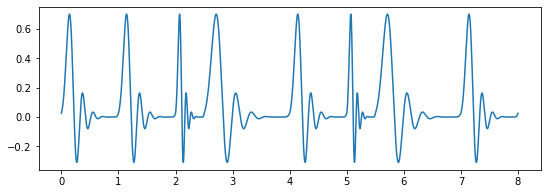

In [7]:
plt.figure(figsize=(9, 3))
plt.plot(t, ecg)
plt.show()

In [8]:
# Dodaj sum
ecg_with_noise = ecg + 0.03 * np.random.randn(1, len(ecg))[0]

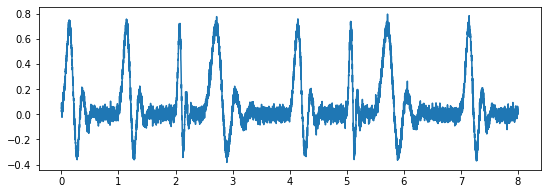

In [9]:
plt.figure(figsize=(9, 3))
plt.plot(t, ecg_with_noise)
plt.show()

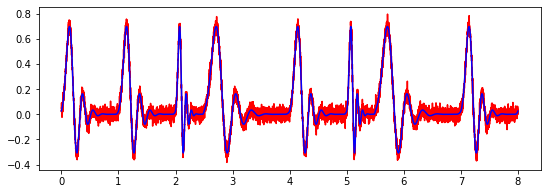

In [10]:
plt.figure(figsize=(9, 3))
plt.plot(t, ecg_with_noise, color = 'r')
plt.plot(t, ecg, color = 'b')
plt.show()

In [11]:
# Duzina signala mora biti stepen broja 2
len(ecg_with_noise)

8192

In [12]:
# Primeni Hadamardovu transformaciju
y = fwht(ecg_with_noise)

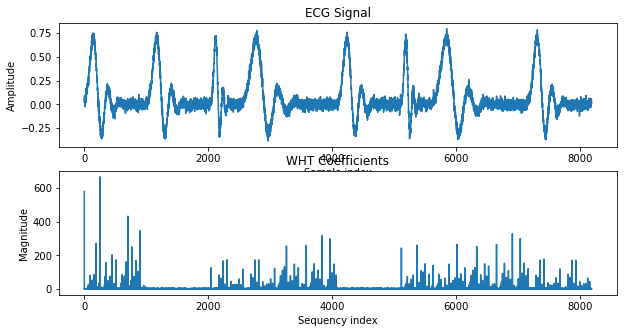

In [13]:
plt.figure(figsize = (10, 5))

plt.subplot(2,1,1)
plt.plot(ecg_with_noise)
plt.xlabel('Sample index')
plt.ylabel('Amplitude')
plt.title('ECG Signal')

plt.subplot(2,1,2)
plt.plot(np.abs(y))
plt.xlabel('Sequency index')
plt.ylabel('Magnitude')
plt.title('WHT Coefficients')

plt.show()

In [14]:
# Sacuvaj prvih 2000 koeficijenata
y_1 = np.append(y[:2000], np.zeros(len(y) - 2000))

# Rekonstruisi pocetni signal
ecg_reverse = ifwht(y_1);

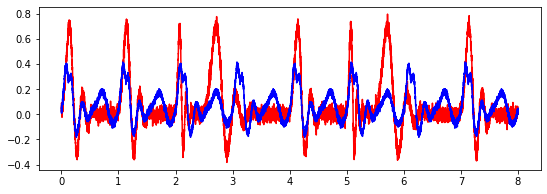

In [15]:
plt.figure(figsize=(9, 3))
plt.plot(t, ecg_with_noise, color = 'r')
plt.plot(t, ecg_reverse, color = 'b')
plt.show()

In [16]:
# Sacuvaj prvih 4200 koeficijenata
y_2 = np.append(y[:4200], np.zeros(len(y) - 4200))

# Rekonstruisi pocetni signal
ecg_reverse = ifwht(y_2);

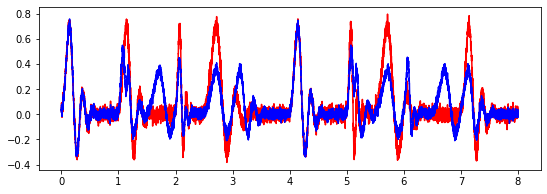

In [17]:
plt.figure(figsize=(9, 3))
plt.plot(t, ecg_with_noise, color = 'r')
plt.plot(t, ecg_reverse, color = 'b')
plt.show()

In [18]:
# Sacuvaj prvih 6000 koeficijenata
y_3 = np.append(y[:6000], np.zeros(len(y) - 6000))

# Rekonstruisi pocetni signal
ecg_reverse = ifwht(y_3);

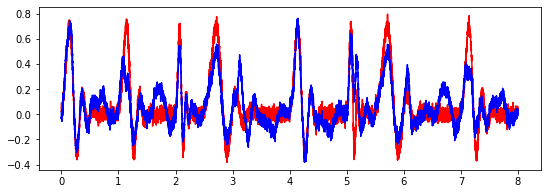

In [19]:
plt.figure(figsize=(9, 3))
plt.plot(t, ecg_with_noise, color = 'r')
plt.plot(t, ecg_reverse, color = 'b')
plt.show()

In [20]:
# Reprodukuj pocetni signal na osnovu svih koeficijenata
ecg_reverse = ifwht(y);

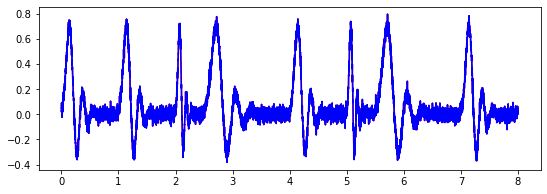

In [21]:
plt.figure(figsize=(9, 3))
plt.plot(t, ecg_with_noise, color = 'r')
plt.plot(t, ecg_reverse, color = 'b')
plt.show()

# Kompresija slike

In [22]:
from PIL import Image

In [23]:
from scipy.linalg import hadamard

In [24]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# Ucitaj sliku
image = Image.open('Slike/slika.png')

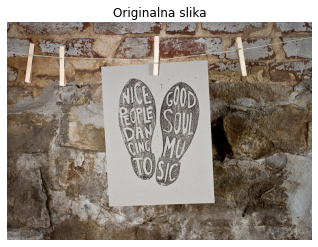

In [26]:
img = np.array(image)
plt.imshow(img)
plt.axis('off')
plt.title('Originalna slika')
plt.show()

In [27]:
# Konvertuj u grayscale i promeni velicinu slike tako da bude stepen dvojke
image = image.convert('L')
image = image.resize((512, 512))

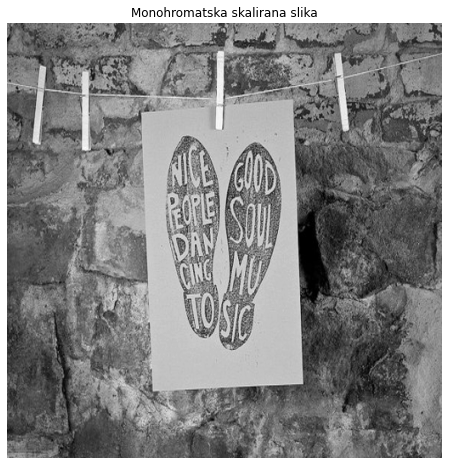

In [28]:
img = np.array(image)
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Monohromatska skalirana slika')
plt.show()

In [29]:
# Skaliraj na 0 i 1
img = img / 256

In [30]:
def walsh_order(n):
    m = hadamard(n)
    
    N = m.shape[0]
    array = np.zeros(N)
    
    for i in range(N):
        row = m[i]
        count = 0
        
        for j in range(N - 1):
            if row[j] * row[j + 1] == -1:
                count += 1
        array[i] = count
            
    a = []
    for i in range(N):
        arg_max = np.argmin(array)
        
        a.append(m[arg_max])
        array[arg_max] = N
        
    return a

In [31]:
W = walsh_order(512)

# Hadamardova 2D transformacija 
transformed_img = (W @ img) @ W
transformed_img = transformed_img / 512

In [32]:
cv2.imshow('Transformed image',transformed_img)
cv2.waitKey(0)

-1

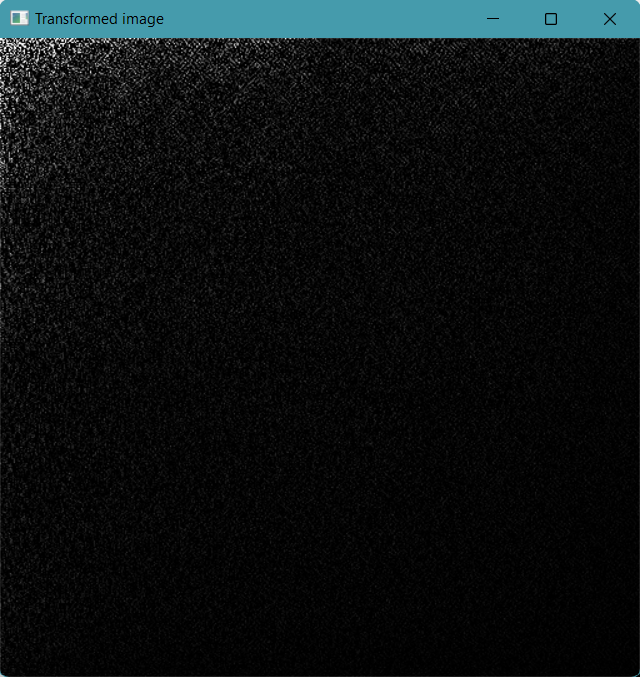

In [33]:
abs_transformed_img = np.abs(transformed_img)

In [34]:
# Sacuvaj koeficijente vece od 0.1
compressed_transformed_img = np.copy(transformed_img)
compressed_transformed_img[abs_transformed_img < 0.1] = 0

# Broj zadrzanih elemenata
np.sum(abs_transformed_img >= 0.1)

49851

In [35]:
cv2.imshow('Compresed transformed image (<0.1)',compressed_transformed_img)
cv2.waitKey(0)

-1

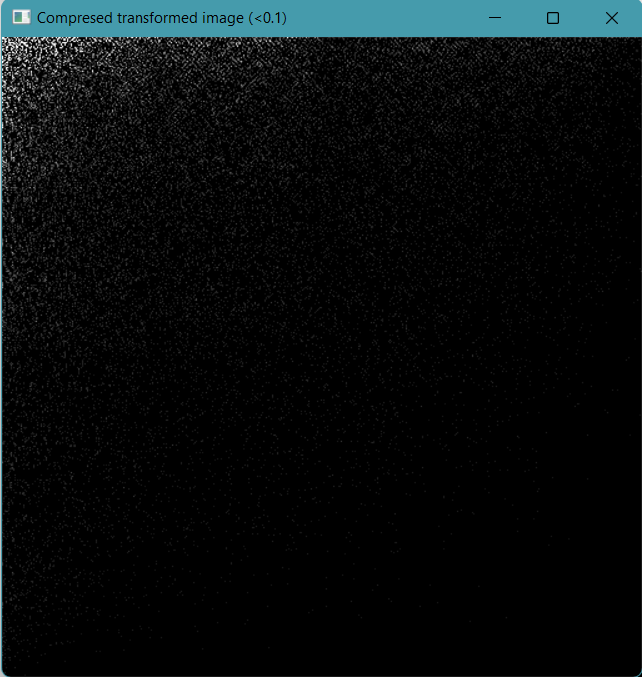

In [36]:
# Rekonsturisi pocetni signal
compressed_image = np.dot(np.dot(W, compressed_transformed_img), W)
compressed_image = compressed_image / 512

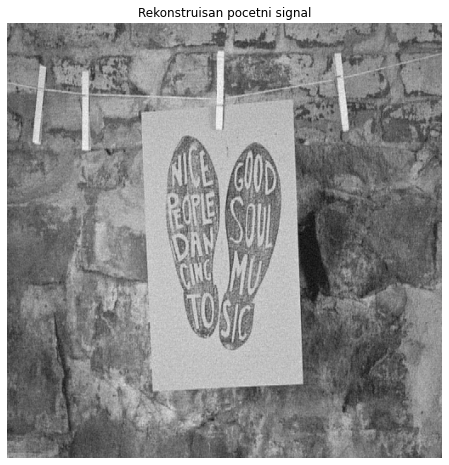

In [37]:
plt.figure(figsize=(8, 8))
plt.imshow(compressed_image, cmap='gray')
plt.axis('off')
plt.title('Rekonstruisan pocetni signal')
plt.show()

In [38]:
cv2.imshow('Compressed image (<0.1)',compressed_image)
cv2.waitKey(0)

-1

In [39]:
# Sacuvaj koeficijente vece od 0.5
compressed_transformed_img = np.copy(transformed_img)
compressed_transformed_img[abs_transformed_img < 0.5] = 0

# Broj zadrzanih elemenata
np.sum(abs_transformed_img >= 0.5)

2365

In [40]:
cv2.imshow('Compresed transformed image (<0.5)',compressed_transformed_img)
cv2.waitKey(0)

-1

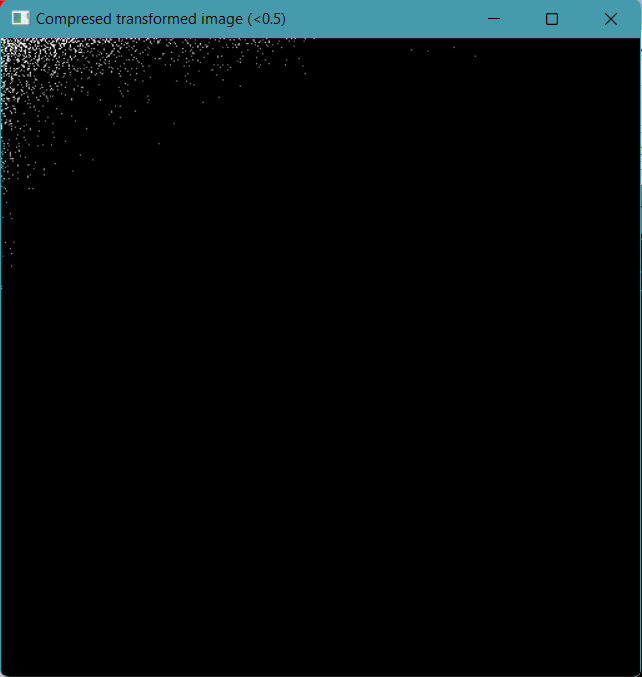

In [41]:
# Rekonsturisi pocetni signal
compressed_image = np.dot(np.dot(W, compressed_transformed_img), W)
compressed_image = compressed_image / 512

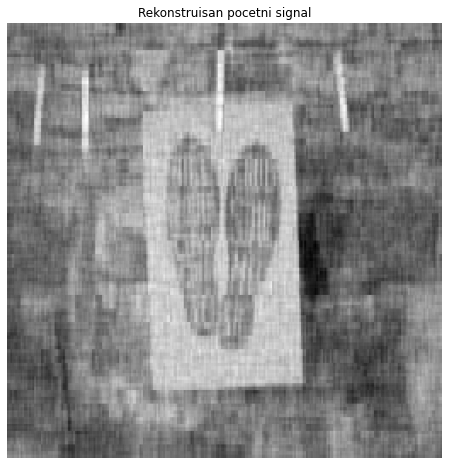

In [42]:
plt.figure(figsize=(8, 8))
plt.imshow(compressed_image, cmap='gray')
plt.axis('off')
plt.title('Rekonstruisan pocetni signal')
plt.show()

In [43]:
cv2.imshow('Compressed image (<0.5)',compressed_image)
cv2.waitKey(0)

-1

In [44]:
# Sacuvaj koeficijente vece od 1
compressed_transformed_img = np.copy(transformed_img)
compressed_transformed_img[abs_transformed_img < 1] = 0

# Broj zadrzanih elemenata
np.sum(abs_transformed_img >= 1)

638

In [45]:
cv2.imshow('Compresed transformed image (<1)',compressed_transformed_img)
cv2.waitKey(0)

-1

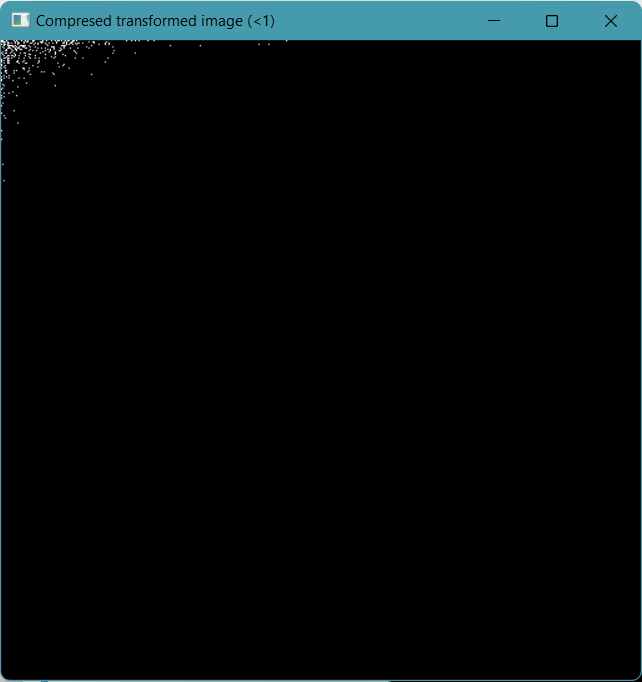

In [46]:
# Rekonsturisi pocetni signal
compressed_image = np.dot(np.dot(W, compressed_transformed_img), W)
compressed_image = compressed_image / 512

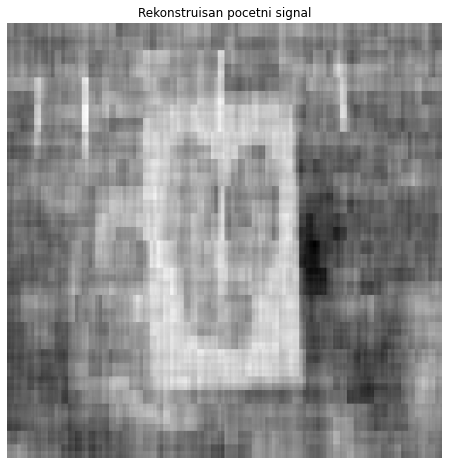

In [47]:
plt.figure(figsize=(8, 8))
plt.imshow(compressed_image, cmap='gray')
plt.axis('off')
plt.title('Rekonstruisan pocetni signal')
plt.show()

In [48]:
cv2.imshow('Compressed image (<1)',compressed_image)
cv2.waitKey(0)

-1

In [49]:
transformed_img_1_4 = transformed_img[:256, :256]
W_256 = walsh_order(256)
compressed_img_1_4 = (W_256 @ transformed_img_1_4) @ W_256
compressed_img_1_4 = compressed_img_1_4 / 256

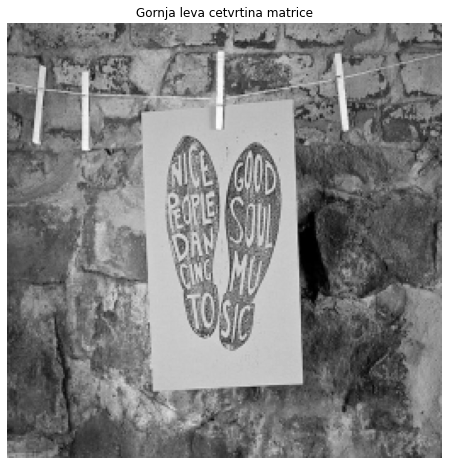

In [50]:
plt.figure(figsize=(8, 8))
plt.imshow(compressed_img_1_4, cmap='gray')
plt.axis('off')
plt.title('Gornja leva cetvrtina matrice')
plt.show()

In [51]:
transformed_img_1_8 = transformed_img[:128, :128]
W_128 = walsh_order(128)
compressed_img_1_8 = (W_128 @ transformed_img_1_8) @ W_128
compressed_img_1_8 = compressed_img_1_8 / 128

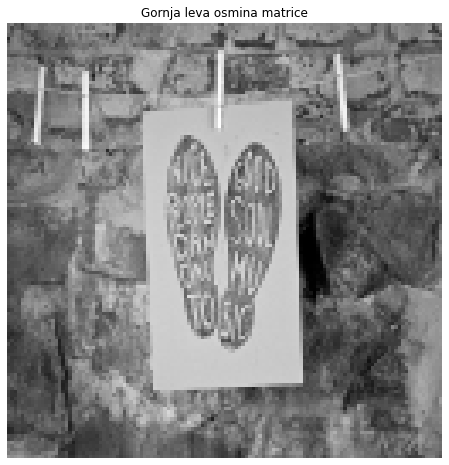

In [52]:
plt.figure(figsize=(8, 8))
plt.imshow(compressed_img_1_8, cmap='gray')
plt.axis('off')
plt.title('Gornja leva osmina matrice')
plt.show()